In [1]:
# Dependencies
import requests
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# import plotly.graph_objects as go
import datetime as DT
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


# API Calls

## Covid Tracking
https://covidtracking.com/api

The following fields are deprecated and are no longer being updated with new data.

/api/v1/states/current.json:
- positiveScore
- negativeScore
- negativeRegularScore
- commercialScore
- score
- grade - Use dataQualityGrade instead
- total

/api/v1/us/current.json
- posNeg
- total

In [2]:
url = "https://covidtracking.com/api/v1"

# Current state data - /api/v1/states/current 
region = "states"
time = "current"
state_current = requests.get(f"{url}/{region}/{time}.json").json()

# Historic state data - /api/v1/states/daily 
region = "states"
time = "daily"
state_daily = requests.get(f"{url}/{region}/{time}.json").json()

# Current US data - /api/v1/us/current
region = "us"
time = "current"
us_current = requests.get(f"{url}/{region}/{time}.json").json()

# Historic US data - /api/v1/us/daily
region = "us"
time = "daily"

us_daily = requests.get(f"{url}/{region}/{time}.json").json()

## Census Popoulation

https://api.census.gov/data/2019/pep/population.html

https://www.census.gov/data/developers/data-sets/popest-popproj/popest.Vintage_2019.html

In [3]:
pop_url = "https://api.census.gov/data/2019/pep/population?get=STATE,POP,NAME&for=state:*"
pop_state = requests.get(f"{pop_url}").json()

## API Calls into Dataframes

In [4]:
pop_df = pd.DataFrame(pop_state, columns = pop_state[0]) 
pop_df = pop_df.drop(pop_df.index[0])
pop_df.head()

,STATE,POP,NAME,state
1,28,2976149,Mississippi,28
2,29,6137428,Missouri,29
3,30,1068778,Montana,30
4,31,1934408,Nebraska,31
5,32,3080156,Nevada,32


In [5]:
state_daily_df = pd.DataFrame(state_daily)
state_daily_df.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200518,AK,399.0,35212.0,NaN,9.0,NaN,NaN,NaN,NaN,...,NaN,35611,35611,35611,02,0.0,0.0,957.0,3.0,960.0
1,20200518,AL,12086.0,145037.0,NaN,NaN,1416.0,NaN,512.0,NaN,...,1416.0,157123,157123,157123,01,1.0,24.0,458.0,315.0,773.0
2,20200518,AR,4813.0,80426.0,NaN,77.0,530.0,NaN,NaN,12.0,...,530.0,85239,85239,85239,05,2.0,10.0,0.0,54.0,54.0
3,20200518,AS,0.0,105.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,105,105,105,60,0.0,0.0,0.0,0.0,0.0
4,20200518,AZ,14170.0,142303.0,NaN,820.0,1717.0,329.0,NaN,200.0,...,1717.0,156473,156473,156473,04,6.0,18.0,4479.0,233.0,4712.0


In [6]:
state_current_df = pd.DataFrame(state_current)
state_current_df.head()

,state,positive,positiveScore,negativeScore,negativeRegularScore,commercialScore,grade,score,notes,dataQualityGrade,...,checkTimeEt,death,hospitalized,total,totalTestResults,posNeg,fips,dateModified,dateChecked,hash
0,AK,399,1.0,1.0,1.0,1.0,A,4.0,"Please stop using the ""total"" field. Use ""tota...",B,...,5/18 16:08,10,NaN,35611,35611,35611,02,2020-05-18T04:00:00Z,2020-05-18T20:08:00Z,08787dee570573cb14704d86c9b153fa2f278dac
1,AL,12086,1.0,1.0,0.0,1.0,B,3.0,"Please stop using the ""total"" field. Use ""tota...",B,...,5/18 16:17,489,1416.0,157123,157123,157123,01,2020-05-18T04:00:00Z,2020-05-18T20:17:00Z,2e1d0b67fdf98e83f24dda52c07f994adb92f34c
2,AR,4813,1.0,1.0,1.0,1.0,A,4.0,"Please stop using the ""total"" field. Use ""tota...",A,...,5/18 16:37,100,530.0,85239,85239,85239,05,2020-05-18T04:00:00Z,2020-05-18T20:37:00Z,53958bf9ceb6af416513ed653b4e0fb050841fb0
3,AZ,14170,1.0,1.0,0.0,1.0,B,3.0,"Please stop using the ""total"" field. Use ""tota...",A+,...,5/18 15:25,686,1717.0,156473,156473,156473,04,2020-05-18T04:00:00Z,2020-05-18T19:25:00Z,dd68234579ea962401c01abc2f7e262d9dc3c46b
4,CA,80430,1.0,1.0,0.0,1.0,B,3.0,"Please stop using the ""total"" field. Use ""tota...",B,...,5/18 15:31,3302,NaN,1292672,1292672,1292672,06,2020-05-17T04:00:00Z,2020-05-18T19:31:00Z,f691a6b335f81c17cebc513cc786190dd1a0ba50


# Data Merging

In [7]:
states_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [8]:
state_daily_df['state_name']=state_daily_df['state'].map(states_dict)

# check if any values did not map
# state_daily_df[state_daily_df['state_name'].isnull()]

state_daily_merged_df = pd.merge (state_daily_df, pop_df, how = "outer", left_on = ["state_name"], right_on = ["NAME"] )

# check if any items did not merge.
# current API call for population is lacking data from American Samoa, Guam, Northern Mariana Islands, Virgin Islands.
# state_daily_df_merged[state_daily_df_merged['NAME'].isnull()]['state_name'].unique()

# Keep the correctly merged items.
state_daily_merged_df = state_daily_merged_df[state_daily_merged_df['NAME'].isnull() == False]

state_daily_merged_df = state_daily_merged_df.rename(columns = {"state_x": "state",
                                      "POP": "2019 population"})
state_daily_merged_df.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,state_name,STATE,2019 population,NAME,state_y
0,20200518,AK,399.0,35212.0,NaN,9.0,NaN,NaN,NaN,NaN,...,0.0,0.0,957.0,3.0,960.0,Alaska,02,731545,Alaska,02
1,20200517,AK,396.0,34255.0,NaN,13.0,NaN,NaN,NaN,NaN,...,0.0,0.0,1366.0,4.0,1370.0,Alaska,02,731545,Alaska,02
2,20200516,AK,392.0,32889.0,NaN,10.0,NaN,NaN,NaN,NaN,...,0.0,0.0,859.0,4.0,863.0,Alaska,02,731545,Alaska,02
3,20200515,AK,388.0,32030.0,NaN,8.0,NaN,NaN,NaN,NaN,...,0.0,0.0,655.0,1.0,656.0,Alaska,02,731545,Alaska,02
4,20200514,AK,387.0,31375.0,NaN,12.0,NaN,NaN,NaN,NaN,...,0.0,0.0,1109.0,4.0,1113.0,Alaska,02,731545,Alaska,02


In [9]:
state_current_df['state_name']=state_current_df['state'].map(states_dict)

# check if any values did not map
# state_daily_df[state_daily_df['state_name'].isnull()]

state_current_merged_df = pd.merge (state_current_df, pop_df, how = "outer", left_on = ["state_name"], right_on = ["NAME"] )

# check if any items did not merge.
# current API call for population is lacking data from American Samoa, Guam, Northern Mariana Islands, Virgin Islands.
# state_current_df_merged[state_current_df_merged['NAME'].isnull()]['state_name'].unique()

# Keep the correctly merged items.
state_current_merged_df = state_current_merged_df[state_current_merged_df['NAME'].isnull() == False]

state_current_merged_df = state_current_merged_df.rename(columns = {"state_x": "state",
                                      "POP": "2019 population"})
state_current_merged_df.head()

,state,positive,positiveScore,negativeScore,negativeRegularScore,commercialScore,grade,score,notes,dataQualityGrade,...,posNeg,fips,dateModified,dateChecked,hash,state_name,STATE,2019 population,NAME,state_y
0,AK,399,1.0,1.0,1.0,1.0,A,4.0,"Please stop using the ""total"" field. Use ""tota...",B,...,35611,02,2020-05-18T04:00:00Z,2020-05-18T20:08:00Z,08787dee570573cb14704d86c9b153fa2f278dac,Alaska,02,731545,Alaska,02
1,AL,12086,1.0,1.0,0.0,1.0,B,3.0,"Please stop using the ""total"" field. Use ""tota...",B,...,157123,01,2020-05-18T04:00:00Z,2020-05-18T20:17:00Z,2e1d0b67fdf98e83f24dda52c07f994adb92f34c,Alabama,01,4903185,Alabama,01
2,AR,4813,1.0,1.0,1.0,1.0,A,4.0,"Please stop using the ""total"" field. Use ""tota...",A,...,85239,05,2020-05-18T04:00:00Z,2020-05-18T20:37:00Z,53958bf9ceb6af416513ed653b4e0fb050841fb0,Arkansas,05,3017804,Arkansas,05
3,AZ,14170,1.0,1.0,0.0,1.0,B,3.0,"Please stop using the ""total"" field. Use ""tota...",A+,...,156473,04,2020-05-18T04:00:00Z,2020-05-18T19:25:00Z,dd68234579ea962401c01abc2f7e262d9dc3c46b,Arizona,04,7278717,Arizona,04
4,CA,80430,1.0,1.0,0.0,1.0,B,3.0,"Please stop using the ""total"" field. Use ""tota...",B,...,1292672,06,2020-05-17T04:00:00Z,2020-05-18T19:31:00Z,f691a6b335f81c17cebc513cc786190dd1a0ba50,California,06,39512223,California,06


# Select Columns

In [10]:
state_daily_merged_df.columns

Index(['date', 'state', 'positive', 'negative', 'pending',
       'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently',
       'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative',
       'recovered', 'dataQualityGrade', 'lastUpdateEt', 'hash', 'dateChecked',
       'death', 'hospitalized', 'total', 'totalTestResults', 'posNeg', 'fips',
       'deathIncrease', 'hospitalizedIncrease', 'negativeIncrease',
       'positiveIncrease', 'totalTestResultsIncrease', 'state_name', 'STATE',
       '2019 population', 'NAME', 'state_y'],
      dtype='object')

In [11]:
select_columns_daily = ['date', 'state', 'positive', 'totalTestResults', "2019 population"]
state_daily_analysis_df_pre = state_daily_merged_df[select_columns_daily]
state_daily_analysis_df_pre.columns = map(str.lower, state_daily_analysis_df_pre.columns)
state_daily_analysis_df_pre.head()

,date,state,positive,totaltestresults,2019 population
0,20200518,AK,399.0,35611,731545
1,20200517,AK,396.0,34651,731545
2,20200516,AK,392.0,33281,731545
3,20200515,AK,388.0,32418,731545
4,20200514,AK,387.0,31762,731545


In [12]:
state_current_merged_df.columns

Index(['state', 'positive', 'positiveScore', 'negativeScore',
       'negativeRegularScore', 'commercialScore', 'grade', 'score', 'notes',
       'dataQualityGrade', 'negative', 'pending', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
       'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered',
       'lastUpdateEt', 'checkTimeEt', 'death', 'hospitalized', 'total',
       'totalTestResults', 'posNeg', 'fips', 'dateModified', 'dateChecked',
       'hash', 'state_name', 'STATE', '2019 population', 'NAME', 'state_y'],
      dtype='object')

In [13]:
select_columns_current = ['state', 'positive', 'totalTestResults', "2019 population"]
state_current_analysis_df_pre = state_current_merged_df[select_columns_current]
state_current_analysis_df_pre.columns = map(str.lower, state_current_analysis_df_pre.columns)
state_current_analysis_df_pre.head()

,state,positive,totaltestresults,2019 population
0,AK,399,35611,731545
1,AL,12086,157123,4903185
2,AR,4813,85239,3017804
3,AZ,14170,156473,7278717
4,CA,80430,1292672,39512223


# Data Cleaning

In [14]:
# checking for null date values
# state_daily_analysis[state_daily_analysis['date'].isnull()]
state_daily_date = state_daily_analysis_df_pre.copy()
state_daily_date['year'] = state_daily_date['date'].astype('str').str[:4]
state_daily_date['month'] = state_daily_date['date'].astype('str').str[4:6]
state_daily_date['day'] = state_daily_date['date'].astype('str').str[6:]
state_daily_date ['date'] = state_daily_date['month']+"-"+state_daily_date['day']+"-"+state_daily_date['year']
state_daily_date ['full_date'] = pd.to_datetime(state_daily_date['date'], format='%m-%d-%Y')
state_daily_date ['full_date'] = state_daily_date ['full_date'].dt.strftime("%m-%d-%Y")

select_columns = ['full_date', 'state','positive', 'totaltestresults', '2019 population']
state_daily_analysis_df = state_daily_date[select_columns]
state_daily_analysis_df.head()

,full_date,state,positive,totaltestresults,2019 population
0,05-18-2020,AK,399.0,35611,731545
1,05-17-2020,AK,396.0,34651,731545
2,05-16-2020,AK,392.0,33281,731545
3,05-15-2020,AK,388.0,32418,731545
4,05-14-2020,AK,387.0,31762,731545


In [15]:
state_current_date = state_current_analysis_df_pre.copy()
state_current_date['full_date'] = pd.to_datetime('today').strftime("%m-%d-%Y")

select_columns = ['full_date', 'state','positive', 'totaltestresults', '2019 population']
state_current_analysis_df = state_current_date[select_columns]
state_current_analysis_df.head()

,full_date,state,positive,totaltestresults,2019 population
0,05-18-2020,AK,399,35611,731545
1,05-18-2020,AL,12086,157123,4903185
2,05-18-2020,AR,4813,85239,3017804
3,05-18-2020,AZ,14170,156473,7278717
4,05-18-2020,CA,80430,1292672,39512223


# Creating Calculated Columns

In [16]:
state_daily_analysis_df ['tests per 1000'] =  state_daily_analysis_df['totaltestresults'].astype(int)/state_daily_analysis_df['2019 population'].astype(int)*1000

state_daily_analysis_df.head()

state_current_analysis_df ['tests per 1000'] =  state_current_analysis_df['totaltestresults'].astype(int)/state_current_analysis_df['2019 population'].astype(int)*1000

state_current_analysis_df.head()

,full_date,state,positive,totaltestresults,2019 population,tests per 1000
0,05-18-2020,AK,399,35611,731545,48.679165
1,05-18-2020,AL,12086,157123,4903185,32.045089
2,05-18-2020,AR,4813,85239,3017804,28.245373
3,05-18-2020,AZ,14170,156473,7278717,21.497333
4,05-18-2020,CA,80430,1292672,39512223,32.715750


In [17]:
state_daily_analysis_df ['positives per 1000'] =  state_daily_analysis_df['positive'].astype(int)/state_daily_analysis_df['2019 population'].astype(int)*1000

state_daily_analysis_df.head()

state_current_analysis_df ['positives per 1000'] =  state_current_analysis_df['positive'].astype(int)/state_current_analysis_df['2019 population'].astype(int)*1000

state_current_analysis_df.head()

,full_date,state,positive,totaltestresults,2019 population,tests per 1000,positives per 1000
0,05-18-2020,AK,399,35611,731545,48.679165,0.545421
1,05-18-2020,AL,12086,157123,4903185,32.045089,2.464928
2,05-18-2020,AR,4813,85239,3017804,28.245373,1.594868
3,05-18-2020,AZ,14170,156473,7278717,21.497333,1.946772
4,05-18-2020,CA,80430,1292672,39512223,32.715750,2.035573


In [18]:
state_daily_analysis_df['positives%'] = state_daily_analysis_df['positive'].astype(int)/state_daily_analysis_df['totaltestresults'].astype(int)

state_daily_analysis_df.head()

state_current_analysis_df['positives%'] = state_current_analysis_df['positive'].astype(int)/state_current_analysis_df['totaltestresults'].astype(int)

state_current_analysis_df.head()

,full_date,state,positive,totaltestresults,2019 population,tests per 1000,positives per 1000,positives%
0,05-18-2020,AK,399,35611,731545,48.679165,0.545421,0.011204
1,05-18-2020,AL,12086,157123,4903185,32.045089,2.464928,0.076921
2,05-18-2020,AR,4813,85239,3017804,28.245373,1.594868,0.056465
3,05-18-2020,AZ,14170,156473,7278717,21.497333,1.946772,0.090559
4,05-18-2020,CA,80430,1292672,39512223,32.715750,2.035573,0.062220


# Creating HeatMaps

In [19]:
# Creating Pivot Tables

# "avg works because there isn't more than one value per crosssection"
state_daily_test_pivot=state_daily_analysis_df.pivot_table(index=['state'], values = 'tests per 1000', columns = "full_date", aggfunc = 'mean')

state_daily_positive_pivot=state_daily_analysis_df.pivot_table(index=['state'], values = 'positives%', columns = "full_date", aggfunc = 'mean')

In [20]:
# calculating last 10 weeks

today = pd.to_datetime('today')
last_week = today - DT.timedelta(days=7)
last_week.date(), today.date()

last_ten_weeks = []

for i in range (10):
    delta = 7*(i)
    delta_date = today - DT.timedelta(days=delta)
        
    last_ten_weeks.append(delta_date.date().strftime("%m-%d-%Y"))
#     last_ten_weeks.append(delta_date.date())
#
    print (delta_date)
last_ten_weeks

2020-05-18 19:24:41.923047
2020-05-11 19:24:41.923047
2020-05-04 19:24:41.923047
2020-04-27 19:24:41.923047
2020-04-20 19:24:41.923047
2020-04-13 19:24:41.923047
2020-04-06 19:24:41.923047
2020-03-30 19:24:41.923047
2020-03-23 19:24:41.923047
2020-03-16 19:24:41.923047


['05-18-2020',
 '05-11-2020',
 '05-04-2020',
 '04-27-2020',
 '04-20-2020',
 '04-13-2020',
 '04-06-2020',
 '03-30-2020',
 '03-23-2020',
 '03-16-2020']

In [38]:
today = last_ten_weeks[0]

state_daily_test_pivot_final = state_daily_test_pivot[last_ten_weeks]
state_daily_test_pivot_final = state_daily_test_pivot_final.iloc[:, ::-1]
state_daily_test_pivot_final.columns = state_daily_test_pivot_final.columns.astype(str)
# pd.options.display.float_format = '{:,.2f}'.format
# pd.set_option('precision', 1)
state_daily_test_pivot_final= state_daily_test_pivot_final.sort_values(by = [today], ascending = False)

state_daily_positive_pivot_final = state_daily_positive_pivot[last_ten_weeks]
state_daily_positive_pivot_final = state_daily_positive_pivot_final.iloc[:, ::-1]
state_daily_positive_pivot_final.columns = state_daily_positive_pivot_final.columns.astype(str)
# pd.options.display.float_format = '{:,.2f}'.format
# pd.set_option('precision', 1)
# state_daily_positive_pivot_final= state_daily_positive_pivot_final.sort_values(by = [today], ascending = True)

merge_rank = state_daily_test_pivot_final.reset_index()['state']
state_daily_positive_pivot_final = pd.merge (merge_rank, state_daily_positive_pivot_final, how = "left", left_on = ["state"], right_on = ["state"] ).set_index('state')

state_daily_positive_pivot_final

,03-16-2020,03-23-2020,03-30-2020,04-06-2020,04-13-2020,04-20-2020,04-27-2020,05-04-2020,05-11-2020,05-18-2020
state,,,,,,,,,,
RI,0.063830,0.084868,0.112009,0.127579,0.144039,0.137457,0.137926,0.130193,0.122680,0.110891
ND,0.008065,0.021692,0.028408,0.031194,0.030702,0.042517,0.041990,0.035248,0.032288,0.034140
NY,0.172947,0.266640,0.356613,0.407371,0.407710,0.390483,0.353465,0.316638,0.279795,0.244083
MA,0.074846,0.075830,0.132021,0.179691,0.219095,0.233380,0.230563,0.213055,0.198775,0.186643
NM,0.029160,0.012068,0.021200,0.032609,0.040800,0.049808,0.048150,0.049374,0.047445,0.044562
LA,0.379538,0.197041,0.118268,0.214947,0.194429,0.180169,0.184150,0.164002,0.144070,0.128672
NJ,0.597315,0.887918,0.397420,0.461519,0.498838,0.498750,0.488148,0.462697,0.328561,0.292817
UT,0.229412,0.050921,0.050366,0.050159,0.051609,0.047035,0.042248,0.042652,0.042249,0.042431
DC,0.150442,0.094386,0.130068,0.147189,0.178800,0.207397,0.211338,0.217273,0.211130,0.192201


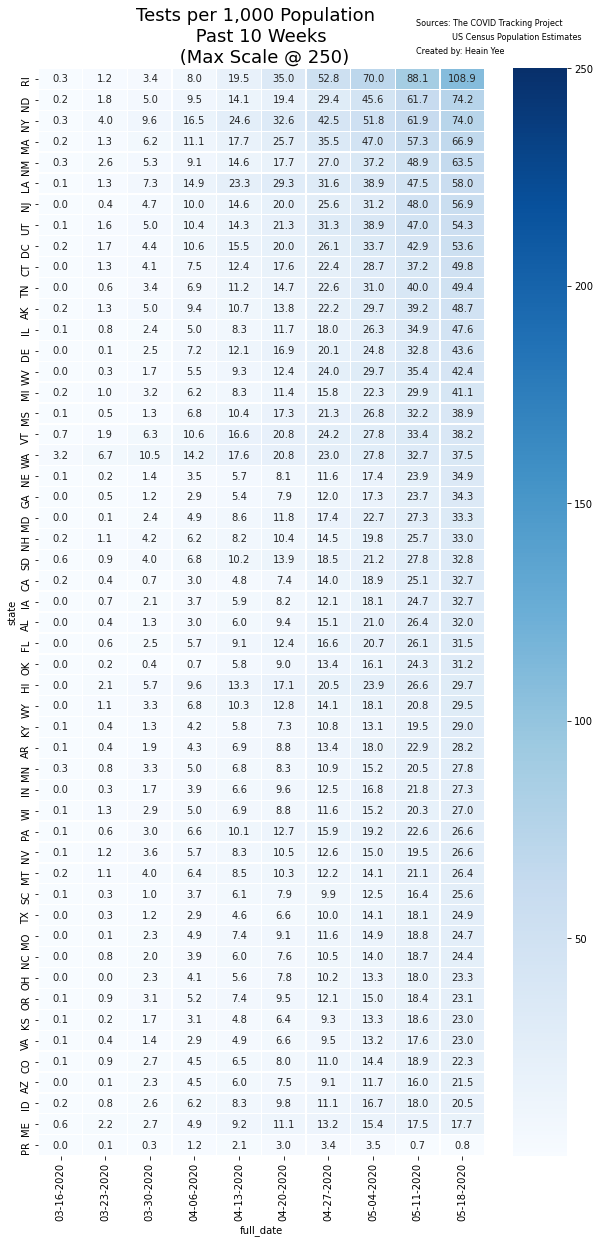

In [42]:
max_scale_tests = 250

fig, ax = plt.subplots(figsize=(10,20))
title = "Tests per 1,000 Population  \n Past 10 Weeks \n (Max Scale @ 250)"

plt.title(title, fontsize=18)

sns.heatmap(state_daily_test_pivot_final, cmap = 'Blues', linewidths = 0.30, annot =True, fmt = '.1f', ax=ax, vmax = max_scale_tests)

textstr = "Sources: The COVID Tracking Project"
plt.gcf().text(.65, .91, textstr, fontsize=8)

textstr = "US Census Population Estimates"
plt.gcf().text(.70, .90, textstr, fontsize=8)

textstr = "Created by: Heain Yee"
plt.gcf().text(.65, .89, textstr, fontsize=8)

plt.savefig("images/HM_testsper1000")

plt.show()

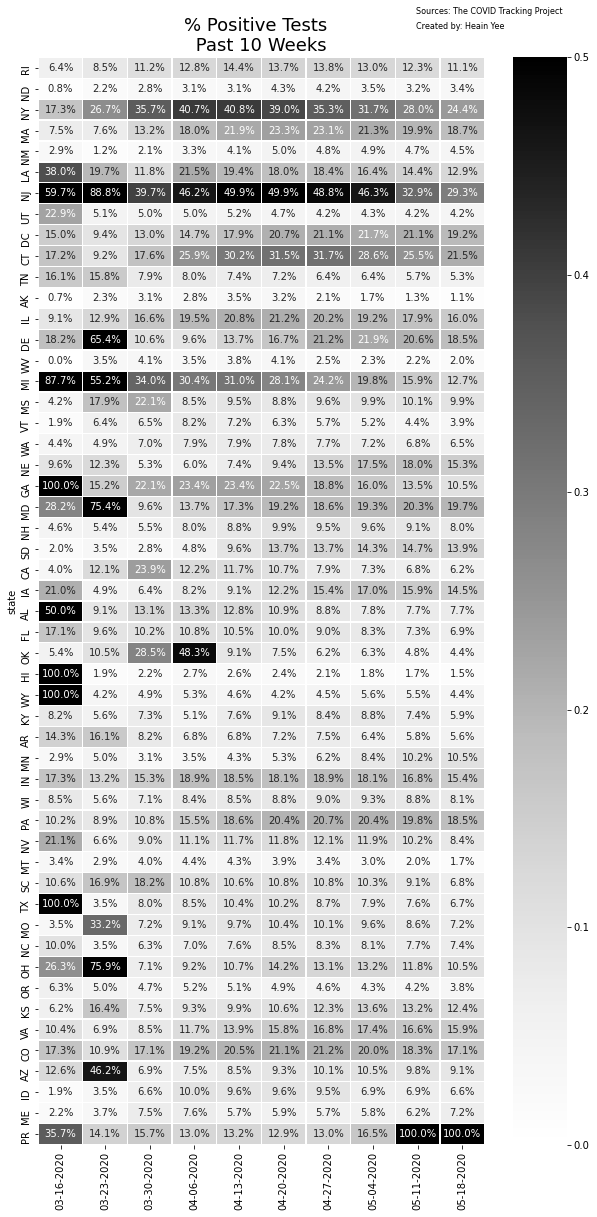

In [80]:
max_scale_positives = .5

fig, ax = plt.subplots(figsize=(10,20))
title = "% Positive Tests  \n Past 10 Weeks "

plt.title(title, fontsize=18)

sns.heatmap(state_daily_positive_pivot_final, cmap = 'Greys', linewidths = 0.30, annot =True, fmt = '.1%', ax=ax, vmax = max_scale_positives)

textstr = "Sources: The COVID Tracking Project"
plt.gcf().text(.65, .91, textstr, fontsize=8)

textstr = "Created by: Heain Yee"
plt.gcf().text(.65, .90, textstr, fontsize=8)

plt.savefig("images/HM_positive%")

plt.show()

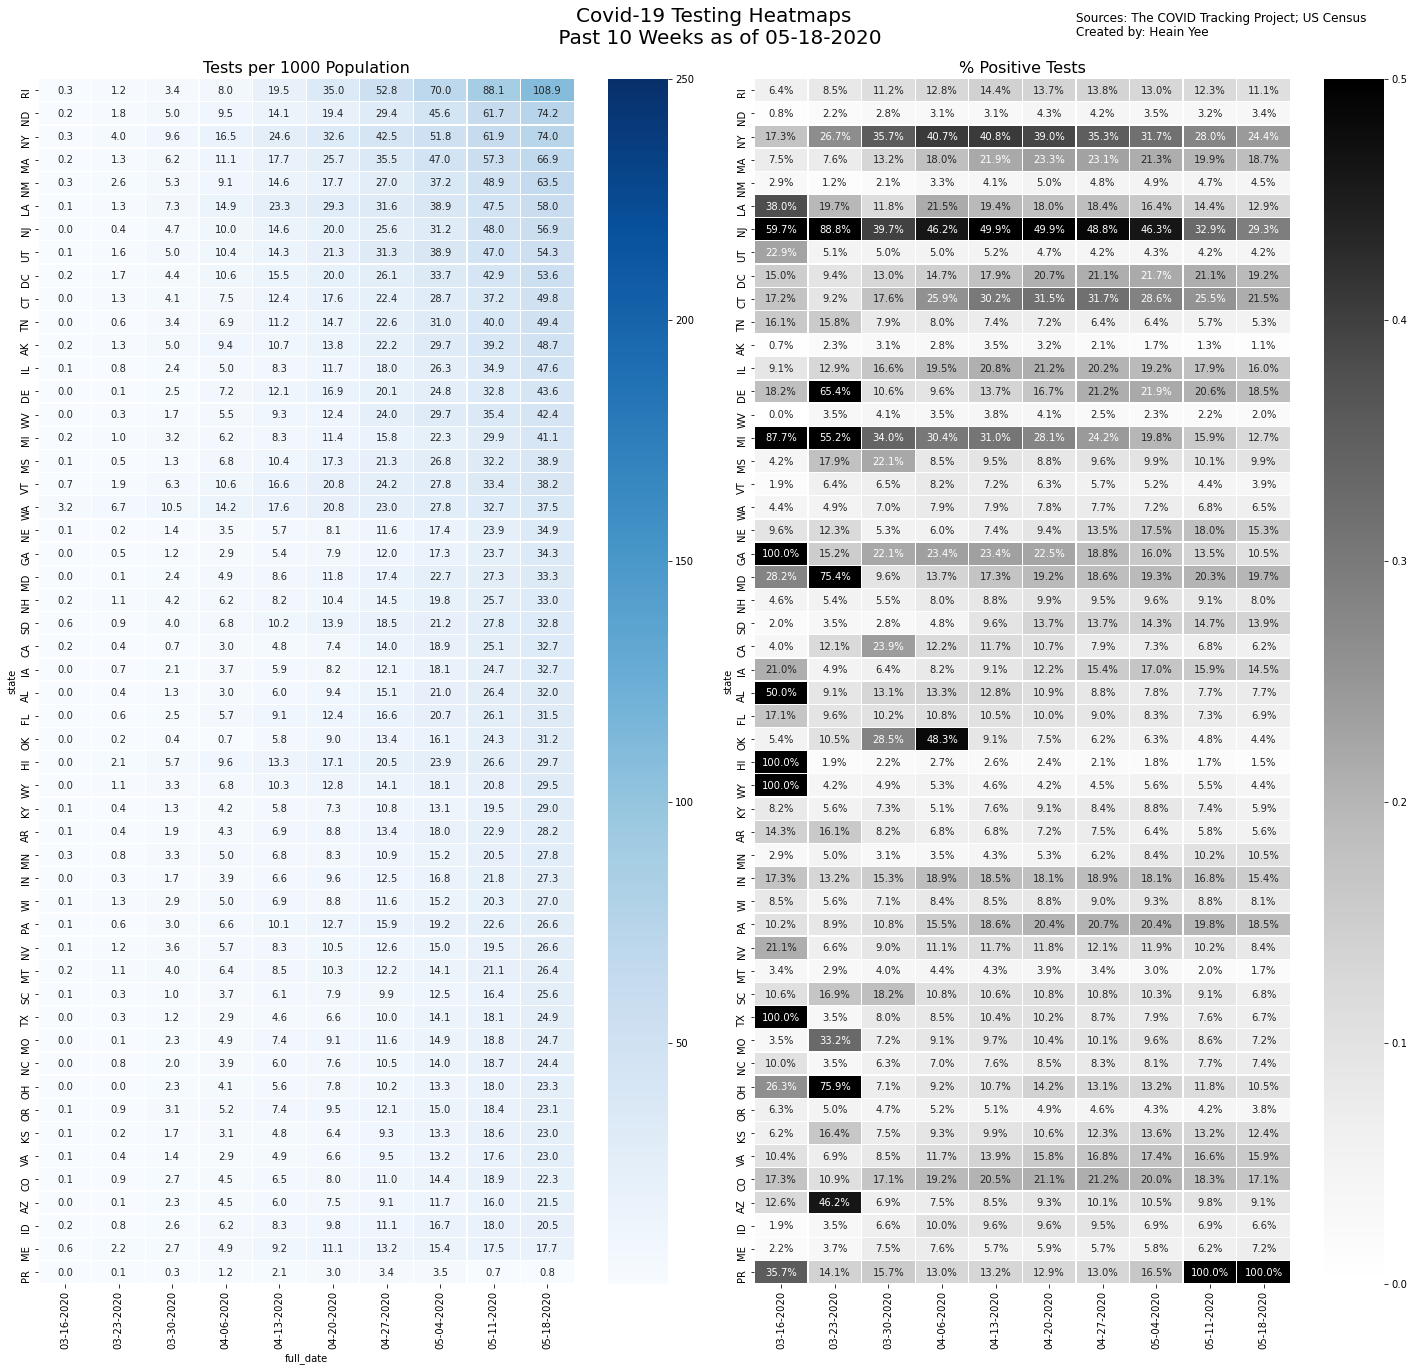

In [79]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
title = f"Covid-19 Testing Heatmaps \n Past 10 Weeks as of {today}"
fig.suptitle(title, fontsize=20)

ax1.set_title("Tests per 1000 Population", fontsize=16)
sns.heatmap(state_daily_test_pivot_final, cmap = 'Blues', linewidths = 0.30, annot =True, fmt = '.1f', ax=ax1, vmax = max_scale_tests, cbar="False")

ax2.set_title("% Positive Tests", fontsize=16)
sns.heatmap(state_daily_positive_pivot_final, cmap = 'Greys', linewidths = 0.30, annot =True, fmt = '.1%', ax=ax2, vmax = max_scale_positives, cbar = "False")

textstr = "Sources: The COVID Tracking Project; US Census"
plt.gcf().text(.75, .97, textstr, fontsize=12)

textstr = "Created by: Heain Yee"
plt.gcf().text(.75, .96, textstr, fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig("images/HM_testing_all")

plt.show()

# Creating Scatterplots
You want to see high levels of tests per capita and decreasing levels of positive tests.

In [25]:
state_current_analysis_df.head()

,full_date,state,positive,totaltestresults,2019 population,tests per 1000,positives per 1000,positives%
0,05-18-2020,AK,399,35611,731545,48.679165,0.545421,0.011204
1,05-18-2020,AL,12086,157123,4903185,32.045089,2.464928,0.076921
2,05-18-2020,AR,4813,85239,3017804,28.245373,1.594868,0.056465
3,05-18-2020,AZ,14170,156473,7278717,21.497333,1.946772,0.090559
4,05-18-2020,CA,80430,1292672,39512223,32.715750,2.035573,0.062220


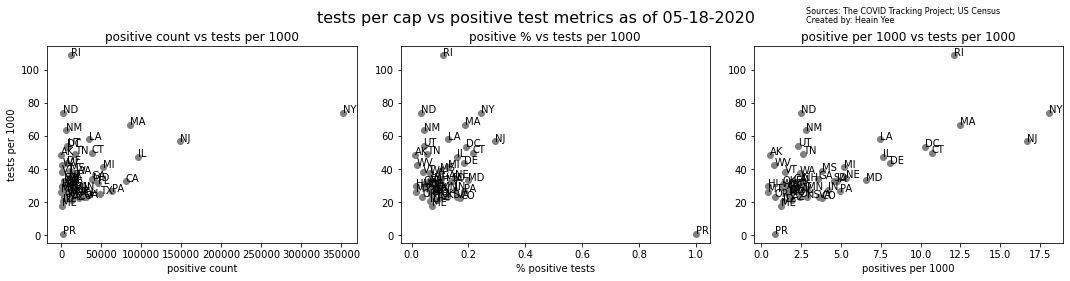

In [26]:
posperc = state_current_analysis_df['positives%']
pospercap = state_current_analysis_df['positives per 1000']
poscount = state_current_analysis_df['positive']
testspercap = state_current_analysis_df['tests per 1000']
varlabel = state_current_analysis_df['state']


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
date = state_current_analysis_df['full_date'][0]
title = f"tests per cap vs positive test metrics as of {date}"
fig.suptitle(title, fontsize=16)

axes[0].set_ylabel("tests per 1000")

axes[0].set_title("positive count vs tests per 1000")
axes[0].plot(poscount, testspercap, 'o', label = varlabel, color='gray')
axes[0].set_xlabel("positive count")

axes[1].set_title("positive % vs tests per 1000")
axes[1].plot(posperc, testspercap, 'o', label = varlabel, color='gray')
axes[1].set_xlabel("% positive tests")
    
axes[2].set_title("positive per 1000 vs tests per 1000")
axes[2].plot(pospercap, testspercap, 'o', label = varlabel, color='gray')
axes[2].set_xlabel("positives per 1000")

for i, txt in enumerate(varlabel):
    axes[0].annotate(txt, (poscount[i], testspercap[i]))
    axes[1].annotate(txt, (posperc[i], testspercap[i]))
    axes[2].annotate(txt, (pospercap[i], testspercap[i]))


textstr = "Sources: The COVID Tracking Project; US Census"
plt.gcf().text(.75, .97, textstr, fontsize=8)

textstr = "Created by: Heain Yee"
plt.gcf().text(.75, .94, textstr, fontsize=8)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig("images/SC_tests-positive_all")

plt.show()

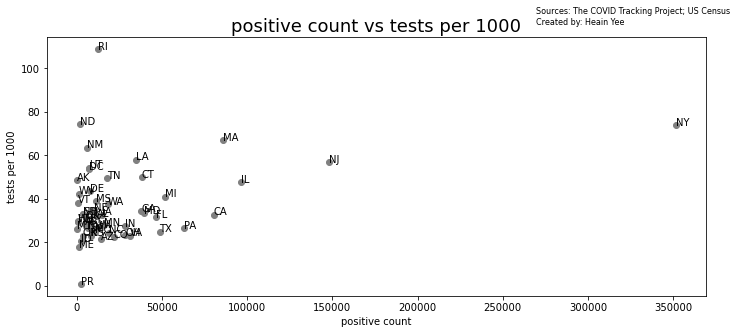

In [27]:
fig = plt.subplots(figsize=(10,5))
title = "positive count vs tests per 1000"

plt.title(title, fontsize=18)

x = state_current_analysis_df['positive']
y = state_current_analysis_df['tests per 1000']
label = state_current_analysis_df['state']

plt.plot(x, y, 'o', label = label, color='gray');

for i, txt in enumerate(varlabel):
    plt.annotate(txt, (x[i], y[i]))

plt.xlabel("positive count")
plt.ylabel("tests per 1000")
    
    
textstr = "Sources: The COVID Tracking Project; US Census"
plt.gcf().text(.75, .93, textstr, fontsize=8)

textstr = "Created by: Heain Yee"
plt.gcf().text(.75, .90, textstr, fontsize=8)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig("images/SC_tests-positivecount")

plt.show()

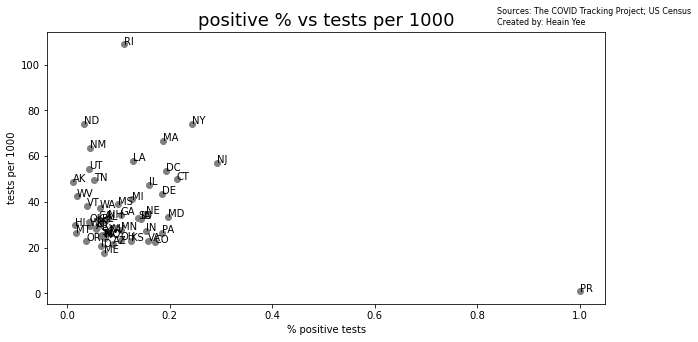

In [28]:
fig = plt.subplots(figsize=(10,5))
title = "positive % vs tests per 1000"

plt.title(title, fontsize=18)

x = state_current_analysis_df['positives%']
y = state_current_analysis_df['tests per 1000']
varlabel = state_current_analysis_df['state']

plt.plot(x, y, 'o', label = varlabel, color='gray');

for i, txt in enumerate(varlabel):
    plt.annotate(txt, (x[i], y[i]))
    
plt.xlabel("% positive tests")
plt.ylabel("tests per 1000")

textstr = "Sources: The COVID Tracking Project; US Census"
plt.gcf().text(.75, .93, textstr, fontsize=8)

textstr = "Created by: Heain Yee"
plt.gcf().text(.75, .90, textstr, fontsize=8)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig("images/SC_tests-positive%")

plt.show()

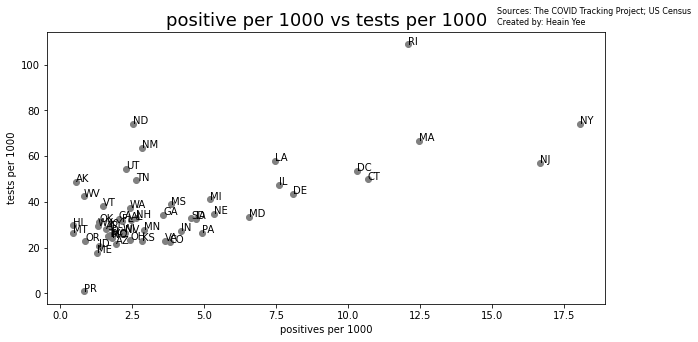

In [29]:
fig = plt.subplots(figsize=(10,5))
title = "positive per 1000 vs tests per 1000"

plt.title(title, fontsize=18)


x = state_current_analysis_df['positives per 1000']
y = state_current_analysis_df['tests per 1000']
label = state_current_analysis_df['state']

plt.plot(x, y, 'o', label = label, color='gray');

for i, txt in enumerate(varlabel):
    plt.annotate(txt, (x[i], y[i]))

plt.xlabel("positives per 1000")
plt.ylabel("tests per 1000")
    
    
textstr = "Sources: The COVID Tracking Project; US Census"
plt.gcf().text(.75, .93, textstr, fontsize=8)

textstr = "Created by: Heain Yee"
plt.gcf().text(.75, .90, textstr, fontsize=8)

plt.savefig("images/SC_tests-positivepercap")

plt.show()